In [1]:
import sys
sys.path.insert(0, '/home/ldoyle/packages')
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import pysindy as ps
from lr_ed import localreg
from datetime import datetime

import scipy.signal as signal

In [2]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"
file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.h5"
file2 = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231214Z.h5"

f = h5py.File(path+file, 'r')
data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
f.close()

# f = h5py.File(path+file2, 'r')
# data2 = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
# timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
# f.close()

In [14]:
mdates.date2num(list(map(datetime.utcfromtimestamp, [timestamp[0], timestamp[-1]])))

array([18932.96614391, 18932.9668383 ])

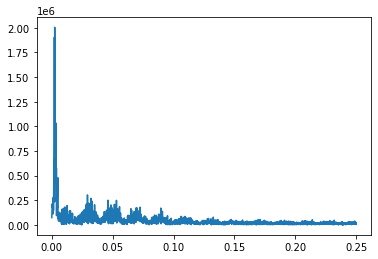

In [48]:
from scipy.fft import fft, fftfreq,rfft2
N=5000
yf1 = fft(data[7500:12500,540])
yf3 = rfft2(data[7500:12500,:])
xf = fftfreq(N, 2)[:N//2]
plt.figure()
plt.plot(xf,2.0/N * np.abs(yf1[:N//2]))
#plt.xlim(0,0.2)
plt.show()


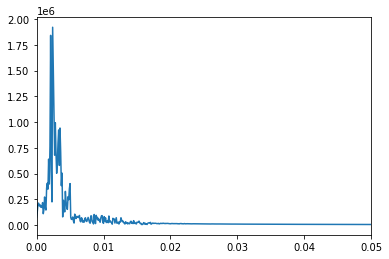

In [44]:
yf2 = fft(smoothed_dat[:,540])

plt.figure()
plt.plot(xf,2.0/N * np.abs(yf2[:N//2]))
plt.xlim(0,0.05)
plt.show()


In [4]:
total_dat = np.append(data,data2,axis=1)

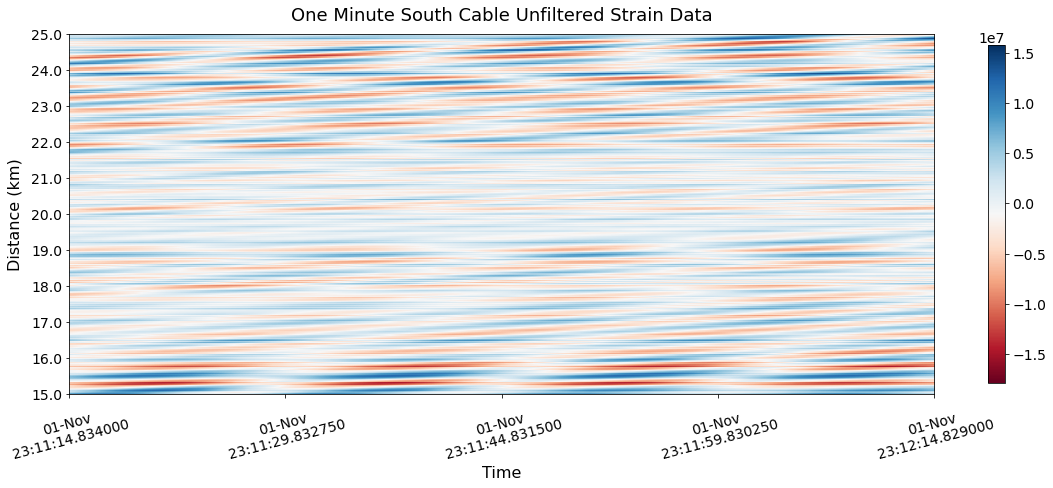

In [64]:
font = {'size'   : 14}

matplotlib.rc('font', **font)

downsample_space=10 # At the scale of plotting, the downsampling is imperceptible
downsample_time=10 # At the scale of plotting, the downsampling is imperceptible

toas = list(map(datetime.utcfromtimestamp, [timestamp[0], timestamp[-1]]))
toas = mdates.date2num(toas)
#x_lims = [0,12000]
y_lims = [7500,12500]
fig, ax = plt.subplots(figsize = (16, 6))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()
im = ax.imshow((data[y_lims[0]:y_lims[1]:downsample_space,::downsample_time]),
               extent = [0,12000,  y_lims[0], y_lims[1]],
               cmap = 'RdBu')

ax.set_xlabel("Time",size=16)
ax.set_ylabel("Distance (km)",size=16, labelpad = 8)#, fontsize = 16)


jump_val = 500

ax.set_xticks(np.linspace(0,12000, 5))#,np.linspace(0,12000, 5)/10000)
ax.xaxis_date()
# date_format = mdates.DateFormatter('%d-%b\n%H:%M:%S.%f')
# ax.xaxis.set_major_formatter(date_format)
ax.set_xticklabels([x.strftime('%d-%b\n%H:%M:%S.%f') for x in mdates.num2date(np.linspace(toas[0], toas[1], 5))])
plt.xticks(rotation=15)

plt.yticks(np.arange(y_lims[0], y_lims[1]+jump_val, jump_val),
           np.round((2/1000)*np.arange(y_lims[0], y_lims[1]+jump_val, jump_val)))

ax.set_title("One Minute South Cable Unfiltered Strain Data",fontsize=18,y=1.02)#file.split('.')[0])
plt.colorbar(im, ax = ax, pad = 0.05,shrink=0.9)
plt.show()

### Kernel Smooth

In [13]:
sliced_data = np.array( data2[7500:12500,:])

In [14]:
def kernel(t):
    res = (1/np.sqrt(2*np.pi))*np.exp(-0.5*t**2)
    return res

In [15]:
radius = 10
size_val = sliced_data.shape[0]
x0 = np.arange(size_val).reshape(-1,1)

weight_matr = np.zeros((size_val,size_val))
incl_list = []
for i, xi in enumerate(x0):
    weight_matr[i,:] = kernel(np.linalg.norm(x0-xi[None,:], axis=1)/radius)

    incl_list.append( np.where(np.abs(weight_matr[i,:])>1e-10)[0])

In [16]:
def gauss_lr(q):
    return localreg(np.arange(size_val),sliced_data[:,q], degree=0, weight_matr=weight_matr,ind_list=incl_list)

In [17]:
smoothed_dat = np.zeros(sliced_data.shape)
for i in tqdm(range(sliced_data.shape[1])):
    smoothed_dat[:,i] = gauss_lr(i)

100%|██████████| 12000/12000 [28:22<00:00,  7.05it/s]


In [18]:
np.save('gaussian_smoothed_2021-11-01T231214Z_channels_7500_12500'+file[:-3]+'.npy', smoothed_dat)

In [67]:
smoothed_dat = np.load('gaussian_smoothed_11_2_2022_channels_7500_12500South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy')

### Bandpass Filter

In [28]:
wp=30
ws=60
N=4
Wn=[10**(-12),69]
# N, Wn = signal.buttord(wp,ws, 3, 40,fs=200)
# b,a = signal.butter(N, Wn,'lp',analog=True)
b,a = signal.butter(N, Wn,'bp',analog=False,fs=200)
data_filt = signal.filtfilt(b,a,data[7500:12500,:].T,axis=0)

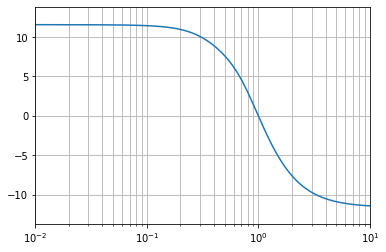

In [29]:
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.show()

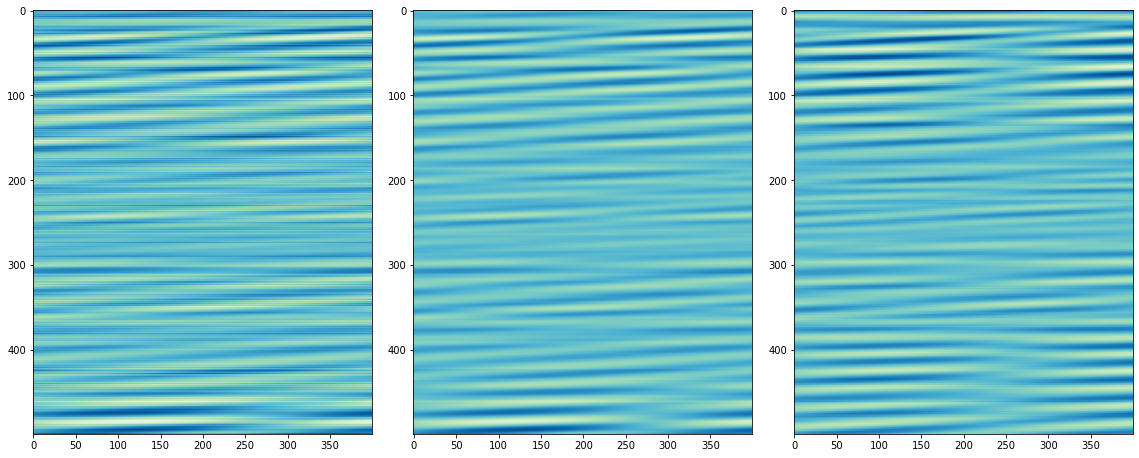

In [30]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize = (16,10))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()

vmin=-16478396

vmax = 12709804

im = ax1.imshow((sliced_data[::10,:4000:10]), vmin=vmin, vmax=vmax,
                cmap = 'GnBu')

im2 = ax2.imshow((smoothed_dat[::10,:4000:10]), vmin=vmin, vmax=vmax,
                cmap = 'GnBu')

im2 = ax3.imshow((data_filt.T[::10,:4000:10]), vmin=vmin, vmax=vmax,
                cmap = 'GnBu')
# plt.xlabel("Time", fontsize = 15)
# plt.ylabel("Channel", fontsize = 15)

# plt.colorbar(im, ax = ax2, pad = 0.04)
plt.show()

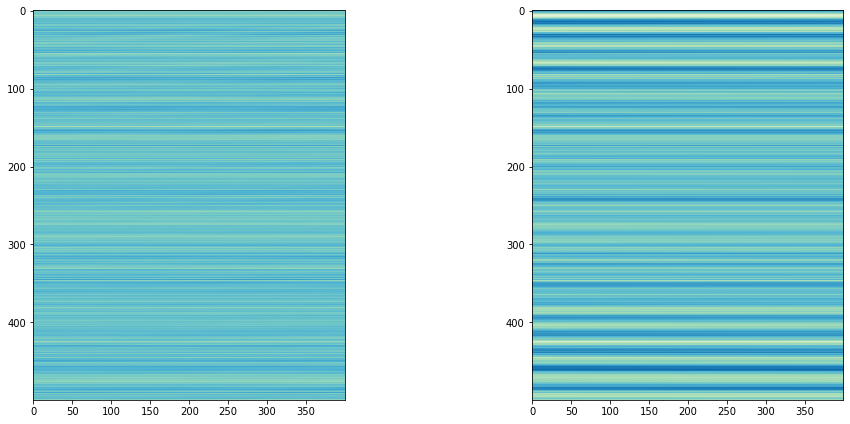

In [93]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize = (14,6))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()

vmin=-15396234

vmax = 12725718.528123552

im = ax1.imshow((smoothed_dat[::10,:4000:10]-sliced_data[::10,:4000:10]), vmin=vmin, vmax=vmax,
                cmap = 'GnBu')

im = ax2.imshow((data_filt.T[::10,:4000:10]-sliced_data[::10,:4000:10]), vmin=vmin, vmax=vmax,
                cmap = 'GnBu')

# im2 = ax3.imshow((data_filt.T[::10,:4000:10]), vmin=vmin, vmax=vmax,
#                 cmap = 'GnBu')
# plt.xlabel("Time", fontsize = 15)
# plt.ylabel("Channel", fontsize = 15)

# plt.colorbar(im, ax = ax2, pad = 0.04)
plt.show()

In [95]:
residuals1 = (smoothed_dat[::10,:4000:10].flatten()-sliced_data[::10,:4000:10].flatten())
residuals2 = (data_filt.T[::10,:4000:10].flatten()-sliced_data[::10,:4000:10].flatten())

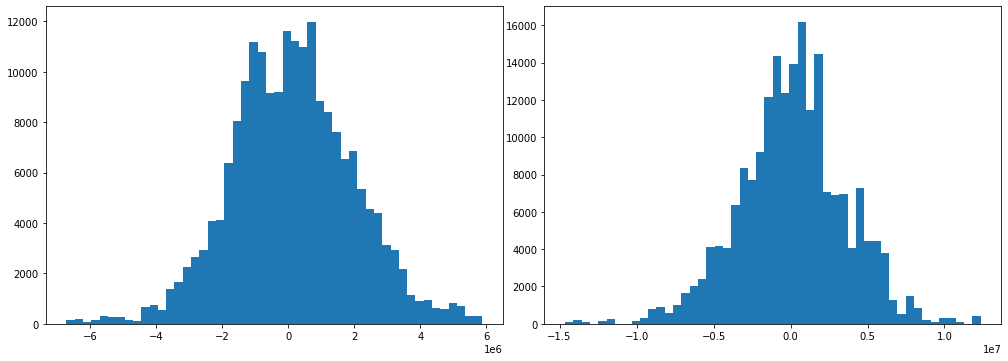

In [97]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize = (14,5))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()
ax1.hist(residuals1,bins=50)
ax2.hist(residuals2,bins=50)
plt.show()

### SINDy

In [96]:
working_dat = smoothed_dat#[::10,::10]
working_dat = working_dat/(np.std(working_dat))

In [97]:
print(np.amax(working_dat))
print(np.amin(working_dat))

3.593980728026395
-3.7064190435906594


In [98]:
working_dat = working_dat.reshape(working_dat.shape[1],working_dat.shape[0],1)
dt=1.
x = np.arange(working_dat.shape[1])

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=x,
    include_bias=True,
    is_uniform=True,
    periodic=True
)

In [99]:
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=8, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt)
model.print()

# print('SR3 model, L0 norm: ')
# optimizer = ps.SR3(
#     threshold=6,
#     max_iter=10000,
#     tol=1e-15,
#     nu=1e2,
#     thresholder="l0",
#     normalize_columns=True,
# )
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(working_dat, t=dt)
# model.print()

# print('SR3 model, L1 norm: ')
# optimizer = ps.SR3(
#     threshold=0.8, max_iter=10000, tol=1e-16, thresholder="l1", normalize_columns=True
# )
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(working_dat, t=dt)
# model.print()

# print('SSR model: ')
# optimizer = ps.SSR(normalize_columns=True, kappa=1.1)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(working_dat, t=dt)
# model.print()

# print('FROLs model: ')
# optimizer = ps.FROLS(normalize_columns=True, kappa=1e-4)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(working_dat, t=dt)
# model.print()

STLSQ model: 
(x0)' = 0.032 x0_1


In [100]:
# full_smooth_dat = (smoothed_dat/np.std(smoothed_dat)).reshape(smoothed_dat.shape[1],smoothed_dat.shape[0],1)
dt=1.
x = np.arange(working_dat.shape[1])

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=x,
    include_bias=True,
    is_uniform=True,
    periodic=True
)

optimizer = ps.STLSQ(threshold=5*10**(-3), alpha=1e-5, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [101]:
print("Ensemble STLSQ ")
model.print()

Ensemble STLSQ 
(x0)' = 0.036 x0_1 + 0.012 x0_111 + -0.006 x0x0x0_1


In [8]:
optimizer = ps.STLSQ(threshold=3*10**(-3), alpha=1e-5, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(full_smooth_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [9]:
print("Ensemble STLSQ 2")
model.print()

Ensemble STLSQ 2
(x0)' = 0.036 x0_1 + 0.014 x0_11 + 0.017 x0_111 + 0.003 x0_1111 + -0.022 x0x0x0_1 + -0.005 x0x0x0_11


In [10]:
optimizer = ps.STLSQ(threshold=6*10**(-3), alpha=1e-5, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(full_smooth_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [11]:
print("Ensemble STLSQ 3")
model.print()

Ensemble STLSQ 3
(x0)' = 0.036 x0_1 + 0.006 x0_11 + 0.009 x0_111 + -0.009 x0x0x0_1


In [14]:
optimizer = ps.STLSQ(threshold=8*10**(-3), alpha=1e-5, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(full_smooth_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [15]:
print("Ensemble STLSQ 4")
model.print()

Ensemble STLSQ 4
(x0)' = 0.035 x0_1 + 0.017 x0_111


In [5]:
# working_dat = smoothed_dat.reshape(smoothed_dat.shape[1],smoothed_dat.shape[0],1)
dt=1.
x = np.arange(smoothed_dat.shape[1])

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=x,
    include_bias=True,
    is_uniform=True,
    periodic=True
)

In [32]:
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=5*10**(-1), alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt)
model.print()

STLSQ model: 
(x0)' = 0.048 x0_1 + 0.029 x0_111 + -0.002 x0x0_111


In [37]:
print('SR3 model, L1 norm: ')
optimizer = ps.SR3(
    threshold=0.1, max_iter=10000, tol=1e-16, thresholder="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt)
model.print()

SR3 model, L1 norm: 
(x0)' = 0.048 x0_1 + 0.029 x0_111 + -0.003 x0x0_11 + -0.002 x0x0_111


### Multi-File

In [2]:
dat_1 = np.load('gaussian_smoothed_11_2_2022_channels_7500_12500South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy')
dat_2 = np.load('gaussian_smoothed_2021-11-01T231214Z_channels_7500_12500South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy')

In [4]:
smoothed_dat = np.hstack((dat_1,dat_2))
smoothed_dat = (smoothed_dat/np.std(smoothed_dat)).reshape(smoothed_dat.shape[1],smoothed_dat.shape[0],1)


In [5]:
smoothed_dat.shape

(24000, 5000, 1)

In [7]:
dt=1.
x = np.arange(smoothed_dat.shape[1])

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=x,
    include_bias=True,
    is_uniform=True,
    periodic=True
)

optimizer = ps.STLSQ(threshold=5*10**(-3), alpha=1e-5, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(smoothed_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [8]:
print("Ensemble STLSQ Multi")
model.print() 

Ensemble STLSQ Multi
(x0)' = 0.034 x0_1 + 0.011 x0_111 + -0.006 x0x0x0_1


In [9]:
optimizer = ps.STLSQ(threshold=3*10**(-3), alpha=1e-5, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(smoothed_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [10]:
print("Ensemble STLSQ Multi 2")
model.print()

Ensemble STLSQ Multi 2
(x0)' = 0.035 x0_1 + 0.017 x0_111 + -0.016 x0x0x0_1 + -0.004 x0x0x0_11


### Weak PDE

In [88]:
working_dat = smoothed_dat[::10,::10]
working_dat = working_dat/(np.std(working_dat))

In [89]:
print(np.amax(working_dat))
print(np.amin(working_dat))

3.573113590045745
-3.6885132296034335


In [90]:
working_dat = working_dat.reshape(working_dat.shape[1],working_dat.shape[0],1)
dt=1.
xs = np.arange(working_dat.shape[1])
time = np.arange(working_dat.shape[0])
X, T = np.meshgrid(xs, time)
XT = np.transpose([X, T], [1, 2, 0])

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatiotemporal_grid=XT,
    include_bias=True,
    is_uniform=True,
    periodic=True
)

/home/ldoyle/packages/pysindy/feature_library/weak_pde_library.py:352: RuntimeWarning: divide by zero encountered in divide
  xtilde_k = [(XT_k[k] - domain_centers[k]) / H_xt_k[k] for k in range(self.K)]
/home/ldoyle/packages/pysindy/feature_library/weak_pde_library.py:352: RuntimeWarning: invalid value encountered in divide
  xtilde_k = [(XT_k[k] - domain_centers[k]) / H_xt_k[k] for k in range(self.K)]
/home/ldoyle/packages/pysindy/feature_library/weak_pde_library.py:513: RuntimeWarning: divide by zero encountered in power
  weights2 = weights2 + [ret * np.product(H_xt_k[k] ** (1.0 - deriv))]
/home/ldoyle/packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [91]:
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=3, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt)
model.print()

# print('SR3 model, L0 norm: ')
# optimizer = ps.SR3(
#     threshold=6,
#     max_iter=10000,
#     tol=1e-15,
#     nu=1e2,
#     thresholder="l0",
#     normalize_columns=True,
# )
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(working_dat, t=dt)
# model.print()

# print('SR3 model, L1 norm: ')
# optimizer = ps.SR3(
#     threshold=0.8, max_iter=10000, tol=1e-16, thresholder="l1", normalize_columns=True
# )
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(working_dat, t=dt)
# model.print()

# print('SSR model: ')
# optimizer = ps.SSR(normalize_columns=True, kappa=1.1)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(working_dat, t=dt)
# model.print()

# print('FROLs model: ')
# optimizer = ps.FROLS(normalize_columns=True, kappa=1e-4)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(working_dat, t=dt)
# model.print()

STLSQ model: 


LinAlgError: Singular matrix